In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
import flika as flk
from skimage.exposure import rescale_intensity as rescale
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
import czifile as czi
flk.start_flika()

Starting flika
Starting flika inside IPython


In [ ]:
fname = '/nrs/ahrens/Yu/expansion/large tile.czi'
# lateral extent of the field of view, in microns
fov = 1100

In [2]:

data_r = czi.imread(fname).squeeze().astype('float32')
bg = data_r.min(1)
data_r = (data_r.transpose(1,0,2,3) - bg).transpose(1,0,2,3)
# channel 0 is NE, 1 is glia
data_c = np.zeros([*data_r.shape[1:], 3], dtype='float32')

In [3]:
ne_in_range = (10,300)
g_in_range=(10,8000)
data_c[:,:,:,0] = rescale(data_r[0].astype('float32'), in_range=ne_in_range, out_range=(0,1))
data_c[:,:,:,1] = rescale(data_r[1].astype('float32'), in_range=g_in_range, out_range=(0,1))
data_c[:,:,:,2] = rescale(data_r[0].astype('float32'), in_range=ne_in_range, out_range=(0,1))

In [34]:
data_c.shape

(615, 1920, 1920, 3)

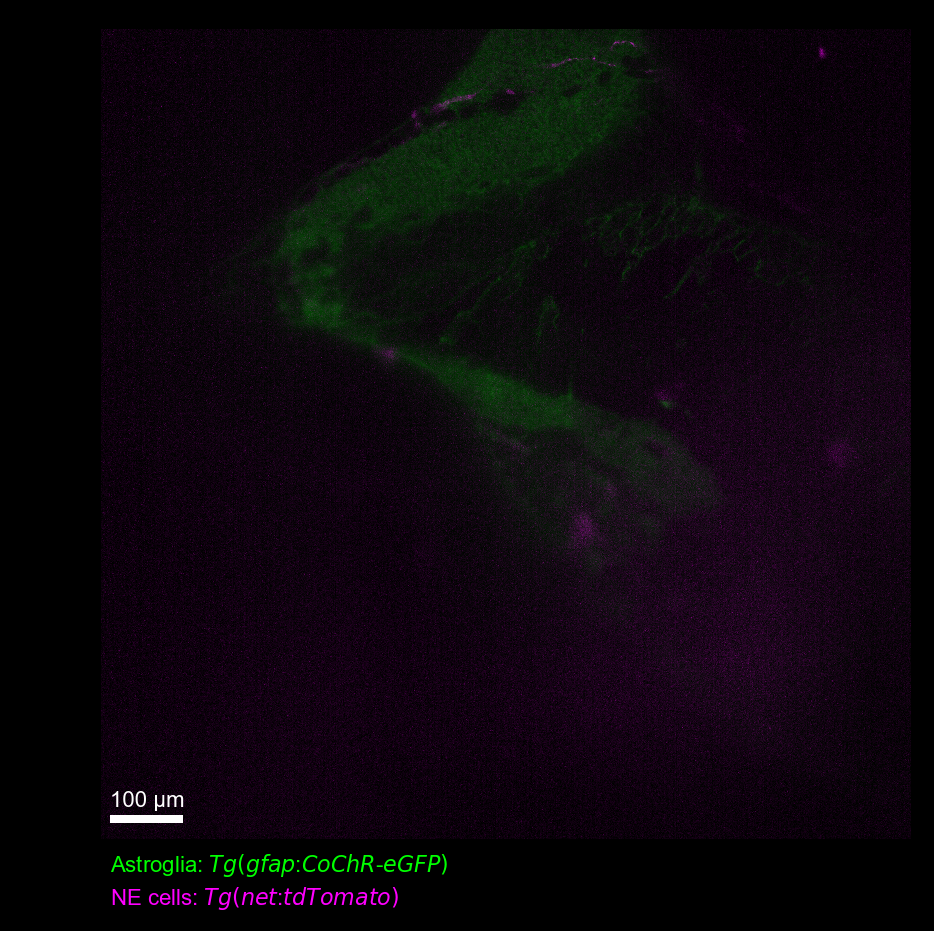

In [76]:
from matplotlib.patches import Rectangle

fps = 24
figsize = (8, 4.5)
plr = slice(15, 320)
fig, axs = plt.subplots(dpi=200, figsize=figsize, facecolor='k')
axs.set_facecolor('k')
axs.axis('off')
axs.set_position([.1,.1,.9,.9])

#length of scale bar, in microns
scale_bar_length = 100

fd_small = {'fontsize' : 8, 'color' : 'w'}

scale_label = dict(x = .01, y=.04, s='100 µm', transform=axs.transAxes, fontdict=dict(color=(1,1,1), size=8))
scale_bar = Rectangle((.01,.02), scale_bar_length/fov, .01, transform = axs.transAxes, facecolor='w')

tdt_label = dict(x = .01, y=-.08, s='NE cells: $\it{Tg(net}$:$\it{tdTomato)}$', transform=axs.transAxes, fontdict=dict(color=(1,0,1), size=8))
gcamp_label = dict(x = .01, y=-.04, s='Astroglia: $\it{Tg(gfap}$:$\it{CoChR}$-$\it{eGFP)}$', transform=axs.transAxes, fontdict=dict(color=(0,1,0), size=8))

axs.add_patch(scale_bar)
axs.text(**scale_label)
axs.text(**tdt_label)
axs.text(**gcamp_label)
ind = 0
axs.imshow(data_c[plr][ind])
def draw_frame(t_):
    global ind
    if t_ == 0.0:
        ind = 0
    axs.images[0].set_data(data_c[plr][ind])
    ind += 1
    return mplfig_to_npimage(fig)

CPU times: user 1.08 s, sys: 345 ms, total: 1.42 s
Wall time: 217 ms


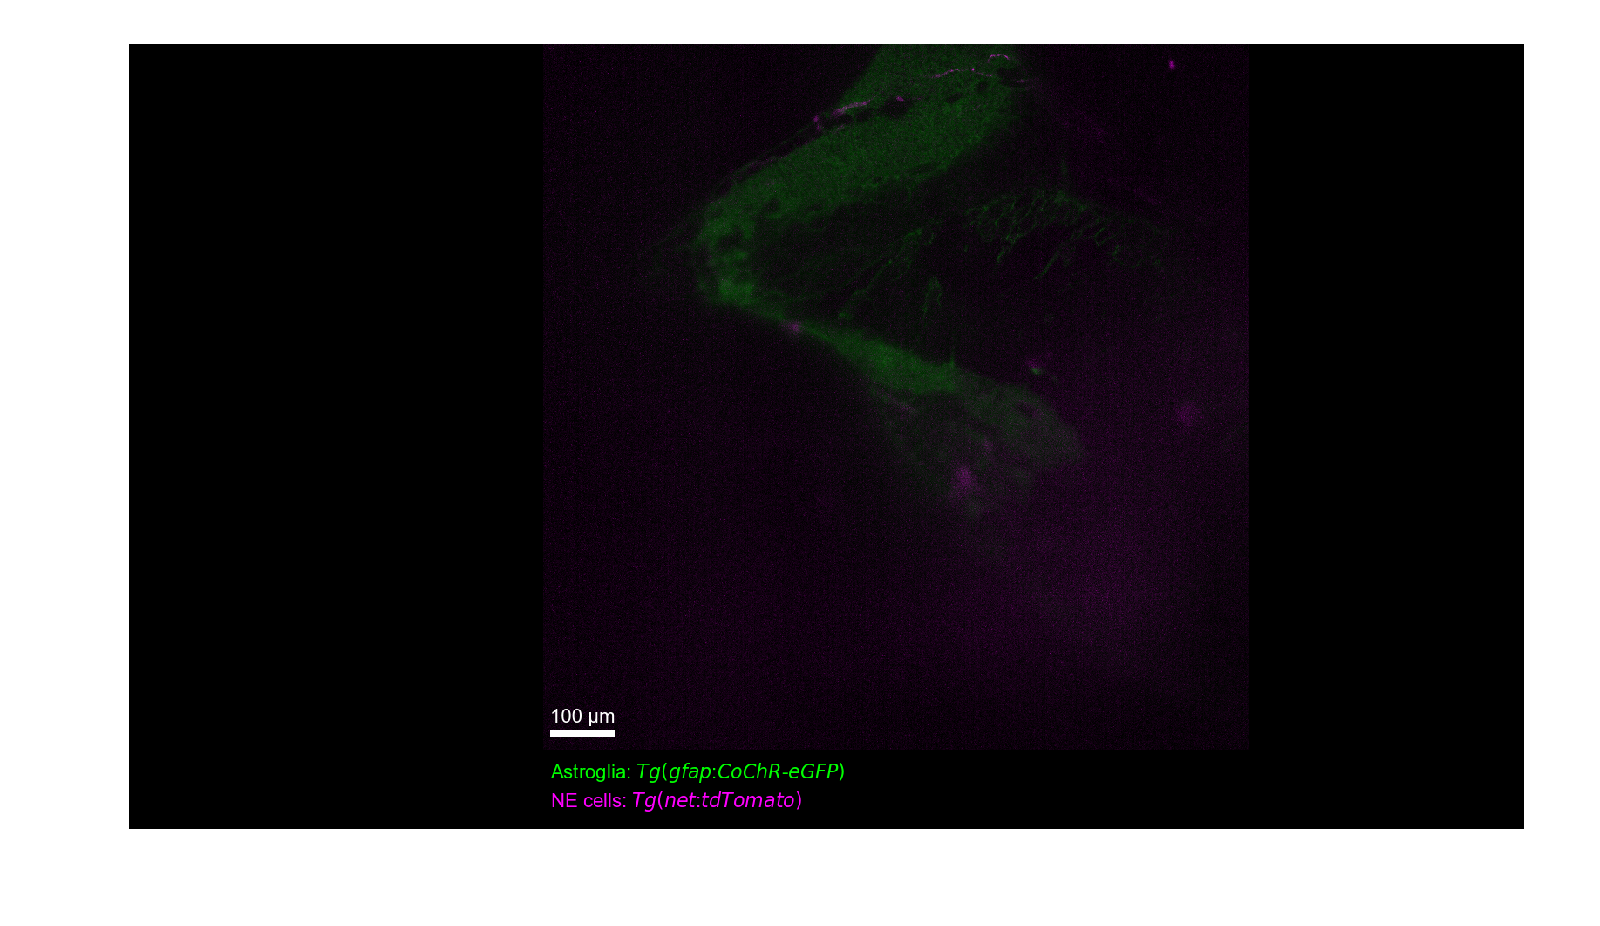

In [77]:
%%time
fig_, axs_ = plt.subplots(dpi=300)
plt.imshow(draw_frame(100))
axs_.axis('off')

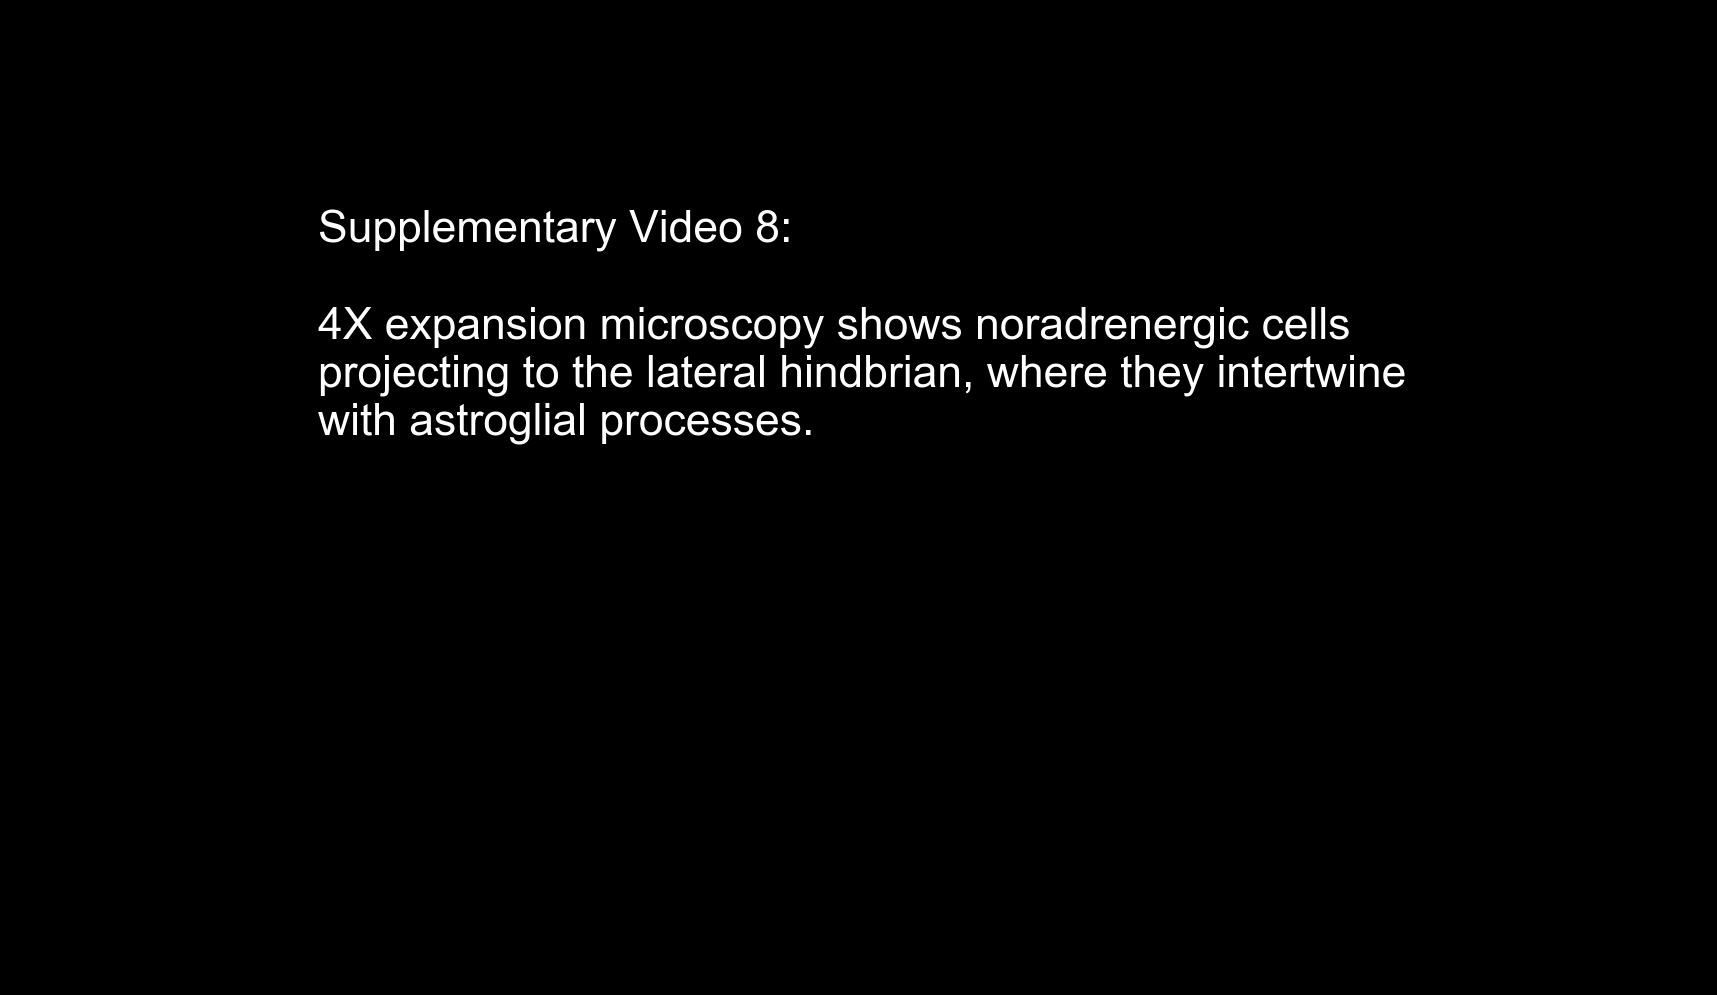

In [78]:
## make the title card 
title_dur = 4
fig_intro = plt.figure(dpi=200, figsize=figsize, facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')
intro_text ='''Supplementary Video 8:

4X expansion microscopy shows noradrenergic cells 
projecting to the lateral hindbrian, where they intertwine 
with astroglial processes.                         
'''
            
ax_intro.text(.15,
              .8,
              intro_text, 
              fontdict=dict(color='w', size=16), 
              transform=ax_intro.transAxes, 
              ha = 'left',
              va='top',
              multialignment='left')

def drawf_intro(t_):
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

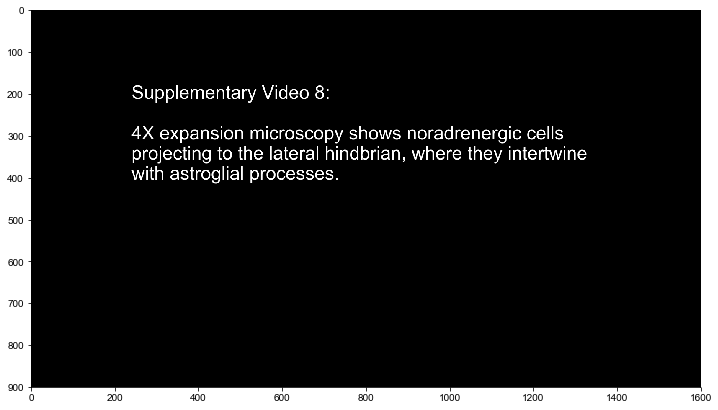

In [79]:
_,_  = plt.subplots(figsize=(12,12))
plt.imshow(drawf_intro(0))

In [ ]:
data_dur = (data_c[plr].shape[0] - 1) / fps
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_8.mp4'
ind = 0 

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])